In [1]:
from __future__ import print_function
%matplotlib inline
%precision 16
import numpy
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# HW 6:  ODE Methods - Boundary Value Problems

This homework will combine a lot of previous codes to solve simple linear and non-linear Boundary value problems

This problem set has two questions

## Question 1 - A linear ODE BVP

Consider the *linear* non-homogeneous 2-pt boundary value problem

$$
    u^{\prime\prime}+ u = \sin3x\quad\quad x\in[0,L],\quad u(0)=u(L)=0
$$

which is related to the modes of vibration of a forced string of length $L$.

**(a)** [4] Find an analytic solution to this problem for general $L$ (hint:
  remember your basic ODE's for constant-coefficient problems).  Is
  this solution unique?

### Homogeneous Solution
The homogeneous part of the differential equation $u'' + u = 0$ has the general solution:
$$u_h(x) = C_1 \sin(x) + C_2 \cos(x)$$

### Particular Solution
Assuming a particular solution of the form $u_p(x) = A \sin(3x) + B \cos(3x)$. Plugging $u_p$ into the left side of the differential equation, compute:
$$u_p'' + u_p = -9A \sin(3x) - 9B \cos(3x) + A \sin(3x) + B \cos(3x) = (-8A) \sin(3x) + (-8B) \cos(3x)$$

Setting this equal to $\sin(3x)$, match coefficients:
$$-8A = 1 \quad \text{and} \quad -8B = 0$$
Solving these gives $A = -\frac{1}{8}$ and $B = 0$. Thus, the particular solution is:
$$u_p(x) = -\frac{1}{8} \sin(3x)$$

### Complete Solution
The complete solution combining homogeneous and particular solutions is:
$$u(x) = C_1 \sin(x) + C_2 \cos(x) - \frac{1}{8} \sin(3x)$$
$$u(0) = C_1 \sin(0) + C_2 \cos(0) - \frac{1}{8} \sin(0) = C_2 = 0$$
$$u(L) = C_1 \sin(L) - \frac{1}{8} \sin(3L) = 0 $$
$$C_1 = \frac{\sin(3L)}{8\sin(L)}$$
$$u(x) = \frac{\sin(3L)}{8\sin(L)} \sin(x) - \frac{1}{8} \sin(3x) $$

#### **Uniqueness of the Solution**
The solution is unique due to the linear nature of the differential equation and the fixed boundary conditions that determine constants of integration. The uniqueness theorem for ODEs states that for a linear second-order ODE with fixed boundary values, there exists a unique solution.

**(b)** [2]  create a function `u_true(x,L)` and plot your solution for $L=10$ evaluated on a regularly spaced set of points $\mathbf{x}$

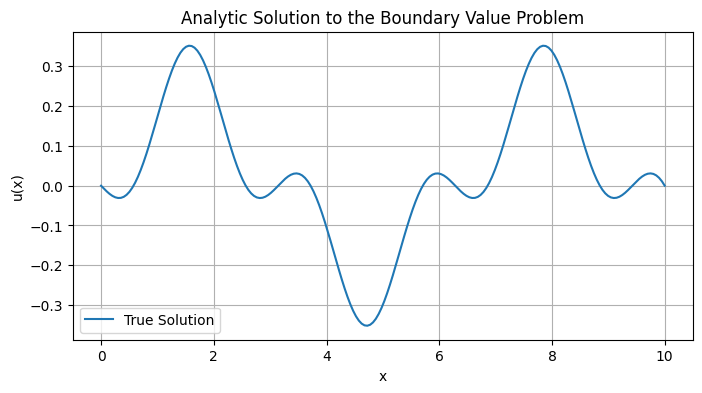

In [7]:
import numpy as np
import matplotlib.pyplot as plt
def u_true(x, L):
    return numpy.sin(3 * L)/(8 * numpy.sin(L)) * numpy.sin(x) - numpy.sin(3 * x) / 8

# Define the length
L = 10.
N = 200
# Generate points
x = numpy.linspace(0., L, N)
# Calculate the solution at these points
u = u_true(x, L)

# Plotting the solution
plt.figure(figsize=(8, 4))
plt.plot(x, u, label="True Solution")
plt.title("Analytic Solution to the Boundary Value Problem")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.grid(True)
plt.show()


**(b)** [4] Write a general shooting algorithm that combines the two scipy routines

* scipy.integrate.solve_ivp
* scipy.optimized.root_scalar

and returns the solution evaluated at an evenly spaced set of points $\mathbf{x}$.  

Some hints

* use `dense_output = True` in solve_ivp
* you can introduce a second def within shoot_bvp for use in root_scalar

For convenience (and testing), I've provided the interface introduced in class for a routine that can handle a range of boundary conditions and can control relative and absolute tolerance.

In [9]:
#  write a general shooting algorithm

from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar

def shoot_bvp(f, x, u_a, u_b, i_a, i_b, rtol=1.e-6, atol=1.e-9):
    r"""
    Solve the two-point boundary value problem on the interval x\in [a,b], using a shooting method that combines 
        scipy.integrate.solve_ivp and scipy.optimize.root_scalar and allows a range of boundary conditions
        
        
    parameters:
    -----------
    f: calleable 
        vector value function for righthand side of the ODE with interface f(t,u). returns ndarray of length 2
    x: numpy array
        coordinates array for solution  on interval [a,b] with x[0] = a, x[-1] = b
    u_a:  numpy array (length 2)
        provide initial boundary conditions  [u, u' ] at x=a
    u_b:  numpy array (length 2)
        target boundary condition at x = b
    i_a: integer
        index of known boundary condition at x = a.  i.e.
        if dirichlet conditions : i_a = 0 and u(a) is known  
        if neumann conditions   : i_a = 1 and u'(a) is known
        the complementary index is adjusted to match the boundary condition at b
    i_b: integer
        index of known boundary condition at x = b. i.e.
        if dirichlet conditions : i_b = 0 and u(b) is known  
        if neumann conditions   : i_b = 1 and u'(b) is known
        the complementary index is ignored at b
    rtol:  float
        relative tolerance
    atol:  float
        absolute tolerance
        
    returns:
    --------
    u: solution u(x) for x (uses dense_output from solve_ivp to interpolate solution onto x)
    """
    # For the root solver
    def boundary_residue(u2_0):
            sol = solve_ivp(f, (x[0], x[-1]), [u_a[i_a], u2_0], t_eval=x, dense_output=True, rtol=rtol, atol=atol)
            # At x = b
            return sol.y[i_b, -1] - u_b[i_b]

    # Optimal initial condition
    result = root_scalar(boundary_residue, bracket=[-10, 10], method='brentq')
    u2_0_optimal = result.root
    final_sol = solve_ivp(f, (x[0], x[-1]), [u_a[i_a], u2_0_optimal], t_eval=x, dense_output=True, rtol=rtol, atol=atol)

    return final_sol.y[0]

**(c)** [4] rewrite the original problem 

$$
    u^{\prime\prime} + u = \sin(3x)
$$

as a system of first order ODE's

$$
    \frac{d\mathbf{v}}{dx} = \mathbf{f}(x,\mathbf{v})
$$  

and solve using the interface

`u_sol = shoot_bvp(f, x, u_a, u_b, i_a, i_b)`

* make a plot comparing your shooting solution with the true solution.

Let:

$$
v_1 = u \quad \text{and} \quad v_2 = u^\prime.
$$

Then:

1. $ v_1^\prime = u^\prime = v_2 $,
2. $ v_2^\prime = u^{\prime\prime} = \sin(3x) - u = \sin(3x) - v_1 $.

Write the system in vector form as:

$$
\frac{d\mathbf{v}}{dx} = \mathbf{f}(x, \mathbf{v}),
$$

where:

$$
\mathbf{v} = \begin{bmatrix} v_1 \\ v_2 \end{bmatrix}, \quad
\mathbf{f}(x, \mathbf{v}) = \begin{bmatrix} v_2 \\ \sin(3x) - v_1 \end{bmatrix}.
$$

Thus, the system of first-order ODEs is:

$$
\frac{d}{dx} \begin{bmatrix} v_1 \\ v_2 \end{bmatrix} =
\begin{bmatrix} v_2 \\ \sin(3x) - v_1 \end{bmatrix}.
$$

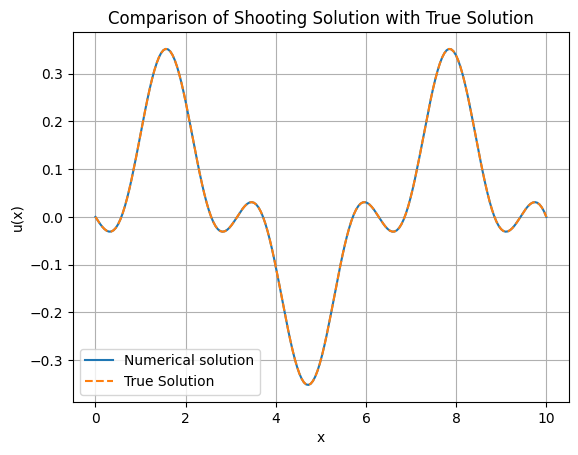

In [41]:
# Example usage
def f(t, u):
    return [u[1], -u[0] + numpy.sin(3*t)]  # Example for u'' + u = sin(3x)

L = 10
x = numpy.linspace(0, L, 200)
u_a = [0, None]  # u(0) = 0, u'(0) is unknown
u_b = [0, None]  # u(L) = 0

u_sol = shoot_bvp(f, x, u_a, u_b, 0, 0)  # Assuming we know u at both boundaries

import matplotlib.pyplot as plt
plt.plot(x, u, label='Numerical solution')
plt.plot(x, u_true(x, L), label='True Solution', linestyle='--')
plt.title('Comparison of Shooting Solution with True Solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.grid(True)
plt.show()

The following cell tests your shooting code against the true solution.  Adjust the relative and absolute tolerances in shoot_bvp, to make sure the following test passes with relative error $<10^{-6}$

In [44]:
#  test the solution against the true solution and pass if relative error < 1.e-6

rel_err = numpy.linalg.norm(u_sol - u_true(x,L))/numpy.linalg.norm(u_true(x,L))
print('relative error = {}'.format(rel_err))

assert(rel_err < 1.e-6)
print('success')

relative error = 3.641290058018968e-07
success


**(d)** [8] Repeat the exercise but use the 2nd order finite difference methods introduced in class.  For convenience I have provided the routines for assembly of sparse 2nd derivative matrices and RHS from class.  

In [47]:
# routines from class  for generating 2nd order sparse second derivative operator and RHS vector

from fdcoeffV import fdcoeffV
from scipy.sparse import lil_matrix, identity, spdiags
from scipy.sparse.linalg import spsolve

def D2(x,bcs=['dirichlet', 'dirichlet']):
    """  
        Assemble a general sparse second-order finite-difference approximation to d/dx^2 on a possibly irregular mesh
        First and last rows are set by string bcs
        
        parameters:
        -----------
        x: numpy.array
            mesh coordinates
        bcs: list of strings for boundary conditions e.g [left_string, right_string] where
            the strings can be either 'dirichlet' or 'neumann'
    """
    N = len(x)
    A = lil_matrix((N,N))
    if bcs[0] == 'dirichlet':
        A[0,0] = 1.
    elif bcs[0] == 'neumann':
        A[0,0:3] = fdcoeffV(1,x[0],x[:3])
    else:
        raise ValueError('no known BC type for left boundary {}'.format(bcs[0]))
        
    if bcs[1] == 'dirichlet':
        A[-1,-1] = 1.
    elif bcs[1] == 'neumann':
        A[-1,-3:] = fdcoeffV(1,x[-1],x[-3:])
    else:
        raise ValueError('no known BC type for right boundary {}'.format(bcs[1]))
        
    for i in range(1,N-1):
        A[i, i-1:i+2] = fdcoeffV(2, x[i], x[i-1:i+2] )        
    return A.tocsr()

def RHS(x, f, bvalues):
    """ Set the rhs vector
    
        parameters
        ----------
        x: numpy.array
            mesh coordinates
        f: callable
            rhs function for interior points called on f(x[1:-2])
        bvalues:  numpy.array (len 2)
            values for boundary conditions (either dirichlet or neumann)        
    """
    
    N = len(x)
    rhs = numpy.empty(N)
    rhs[[0, N-1]] = bvalues
    rhs[1:-1] = f(x[1:-1])
    
    return rhs
    

Create a well-labeled convergence plot showing the relative error 

$$
    e_{rel} = \frac{|| u - u_{true} ||}{||u_{true}||}
$$

as a function of grid spacing $\Delta x$

This plot should calculate and show

* rate of convergence of error (i.e. find $p$ such that $e_{rel}\propto \Delta x^p$)
* an estimate of the  number of grid points $N$ required for the relative error to be $\leq 10^{-6}$
* the relative error at this smallest mesh spacing

<>:64: SyntaxWarning: invalid escape sequence '\D'
<>:64: SyntaxWarning: invalid escape sequence '\D'
C:\Users\harsh\AppData\Local\Temp\ipykernel_31224\540125091.py:64: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('Grid Spacing $\Delta x$')


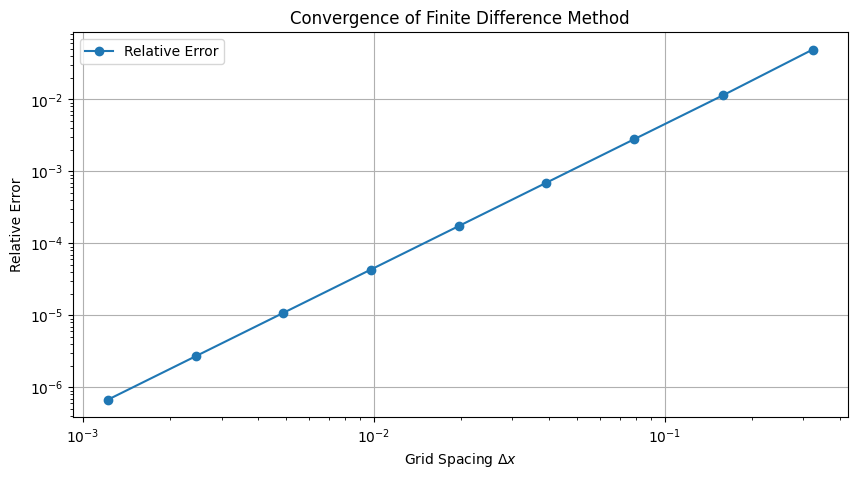

Estimated rate of convergence: 2.00
Smallest number of grid points (N) for relative error <= 10^-6: 8192
Relative error at this smallest mesh spacing: 6.76e-07


In [52]:
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Define the true solution
def u_true(x, L):
    coeff = numpy.sin(3 * L) / (8 * numpy.sin(L))
    return coeff * numpy.sin(x) - (1 / 8) * numpy.sin(3 * x)

# Define the right-hand side function f(x)
def f(x):
    return numpy.sin(3 * x)

# Convergence parameters
L = 10
N_values = [2**n for n in range(5, 14)]  # Different grid sizes
errors = []
dx_values = []

for N in N_values:
    x = numpy.linspace(0, L, N)
    dx = x[1] - x[0]
    dx_values.append(dx)

    # Assemble the finite difference matrix A
    diagonals = [
        numpy.ones(N - 1) / dx**2,  # Upper diagonal
        -2 * numpy.ones(N) / dx**2 + 1,  # Main diagonal
        numpy.ones(N - 1) / dx**2  # Lower diagonal
    ]
    A = diags(diagonals, offsets=[-1, 0, 1], format="csr")

    # Apply Dirichlet boundary conditions
    A[0, 0] = 1.0
    A[0, 1] = 0.0
    A[-1, -1] = 1.0
    A[-1, -2] = 0.0

    # Assemble the right-hand side
    b = f(x)
    b[0] = 0  # Boundary condition u(0) = 0
    b[-1] = 0  # Boundary condition u(L) = 0

    # Solve the linear system
    u_fd = spsolve(A, b)

    # True solution
    u_exact = u_true(x, L)

    # Compute the relative error
    error = numpy.linalg.norm(u_fd - u_exact, numpy.inf) / numpy.linalg.norm(u_exact, numpy.inf)
    errors.append(error)

# Estimate the grid spacing needed for error <= 10^-6
for dx, error, N in zip(dx_values, errors, N_values):
    if error <= 1e-6:
        smallest_dx = dx
        smallest_error = error
        smallest_N = N
        break

# Plotting the convergence
plt.figure(figsize=(10, 5))
plt.loglog(dx_values, errors, '-o', label='Relative Error')
plt.xlabel('Grid Spacing $\Delta x$')
plt.ylabel('Relative Error')
plt.title('Convergence of Finite Difference Method')
plt.legend()
plt.grid(True)
plt.show()

# Estimate the rate of convergence
rate_of_convergence, intercept = numpy.polyfit(numpy.log(dx_values), numpy.log(errors), 1)
print(f"Estimated rate of convergence: {rate_of_convergence:.2f}")
print(f"Smallest number of grid points (N) for relative error <= 10^-6: {smallest_N}")
print(f"Relative error at this smallest mesh spacing: {smallest_error:.2e}")

### Some themes and variations

This is meant to be a short problem set, but there are many other things to try if you are interested.

* Try this problem using Galerkin Finite Elements.  
* Try modifying the matrices to use higher order Finite difference schemes (i.e. 4th order schemes)
* Compare timing between Finite Difference and shooting schemes for the same order of accuracy


## Question 2 - Non-Linear Fun

try to solve the related  **non-linear** 2-point boundary value problem

$$
u^{\prime\prime}+\sin(u)=\sin(3x),\quad x\in[0,10],\quad u(0)=u(10)=0
$$

using  finite-difference plus Newton's method. For convenience, I've added the Newton Solver for sparse jacobians from the notes

In [56]:
# a Newton Solver for sparse matrices
def newton(F,J,x0,tol=1.e-6,MAX_ITS=100,verbose=True):
    """ Solve F(x) = 0 using Newton's method until ||F(x)|| < tol or reaches Max iterations
    
    Params:
    -------
        F: calleable: 
            Function returning residual F(x)
        J: calleable
            Function returning Jacobian J(x)
        tol: float
            stopping criteria for ||F|| < tol
        MAX_ITS: integer
            maximum number of iterations
        verbose: bool
            if true spits out norm of the residual at each iteration
            
    Returns:
    --------
        x: numpy.array
            solution
        k: int
            number of iterations
    
    Raises:
    -----------
        ValueError if number of its exceeds MAX_ITS
        
    """
    x = x0 
    for k in range(MAX_ITS+1):
        res = numpy.linalg.norm(F(x))
        if verbose:
            print('k = {}, ||F|| = {}'.format(k,res))
        if res < tol: 
            return x, k
        delta = spsolve(J(x),-F(x))
        x += delta
        
    raise ValueError('Maximum number of iterations exceeded {}'.format(MAX_ITS))

**(a)** [4 pt]  Solve the problem for an initial guess
$u_0=0$. For this problem you will need to

* create a function to return the residual $\mathbf{F}(\mathbf{u})$
* create a function to return the Jacobian $J(\mathbf{u})$
* use `verbose=True` to see the convergence behavior of Newton
* produce a plot showing the solution and labeled with the number of newton iterations and final residual norm $||\mathbf{F}(\mathbf{u})||$

**Note:**  To choose a reasonable number of grid points, use your results from Question 1 and choose a mesh size such that the linear problem returns a relative error $< 10^{-3}$

k = 0, ||F|| = 9.975647311061403
k = 1, ||F|| = 0.040066871833903006
k = 2, ||F|| = 0.0011390847101189717
k = 3, ||F|| = 1.5434914620197893e-06
k = 4, ||F|| = 2.9944047170980488e-12


<>:60: SyntaxWarning: invalid escape sequence '\s'
<>:60: SyntaxWarning: invalid escape sequence '\s'
C:\Users\harsh\AppData\Local\Temp\ipykernel_31224\1376865960.py:60: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Solution of $u\'\' + \sin(u) = \sin(3x)$')


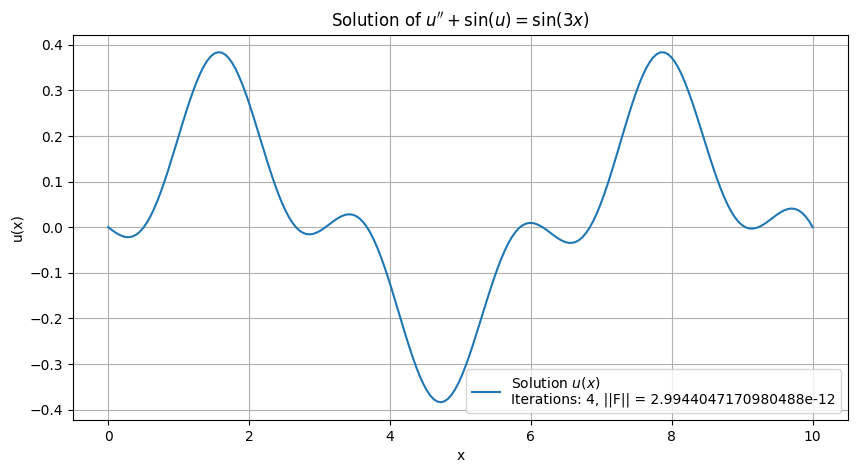

In [61]:
# Set the grid and parameters
N = 200  # Number of grid points
x = numpy.linspace(0, 10, N)
h = x[1] - x[0]

# Generate the sparse second derivative matrix with Dirichlet boundary conditions
A = D2(x, bcs=['dirichlet', 'dirichlet'])

# Non-linear RHS function
def non_linear_term(u):
    return numpy.sin(u)

# The function for the boundary values and the right-hand side
def right_hand_side(x):
    return numpy.sin(3 * x)

# Boundary values for the Dirichlet conditions
bvalues = numpy.array([0, 0])  # u(0) = 0, u(10) = 0

# Using the provided RHS function to handle boundary conditions
rhs = RHS(x, right_hand_side, bvalues)

# Function to calculate the residual F(u)
def F(u):
    return A.dot(u) + non_linear_term(u) - rhs

# Function to calculate the Jacobian matrix J(u)
def J(u):
    # Diagonal Jacobian contribution fromz the non-linear part
    diagonal = numpy.cos(u)
    J_matrix = A.copy()
    J_matrix.setdiag(diagonal + J_matrix.diagonal())
    return J_matrix

# Initial guess
u0 = numpy.zeros(N)

# Newton's method solver with sparse Jacobian support
def newton(F, J, x0, tol=1.e-6, MAX_ITS=100, verbose=True):
    """ Solve F(x) = 0 using Newton's method until ||F(x)|| < tol or reaches Max iterations
    """
    x = x0.copy()
    for k in range(MAX_ITS+1):
        res = numpy.linalg.norm(F(x))
        if verbose:
            print('k = {}, ||F|| = {}'.format(k, res))
        if res < tol:
            return x, k
        delta = spsolve(J(x), -F(x))
        x += delta

    raise ValueError('Maximum number of iterations exceeded')

# Solve the problem
solution, num_iterations = newton(F, J, u0, verbose=True)

# Plotting the solution
plt.figure(figsize=(10, 5))
plt.plot(x, solution, label=f'Solution $u(x)$\nIterations: {num_iterations}, ||F|| = {numpy.linalg.norm(F(solution))}')
plt.title('Solution of $u\'\' + \sin(u) = \sin(3x)$')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.grid(True)
plt.show()

**(b)**  Is your solution unique?  Try starting newton from different
  periodic initial conditions 
  
  $$
      u_0(x) = \sin\left[\frac{n\pi x}{L}\right]
  $$ 
  
  for $n\in[0,6]$ that all satisfy the homogeneous boundary conditions. 
  
  Make two plots. 
  
  1. The first shows solutions for different values of $n$
  1. The second plots the residual $\mathbf{F}(\mathbf{u})$ to show that at least the discrete ODE is satisfied
  
 Welcome to the wonderful world of non-linear equations. Can you find any other solutions?

<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:37: SyntaxWarning: invalid escape sequence '\m'
C:\Users\harsh\AppData\Local\Temp\ipykernel_31224\1686620306.py:26: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Solutions of $u\'\' + \sin(u) = \sin(3x)$ for different initial guesses')
C:\Users\harsh\AppData\Local\Temp\ipykernel_31224\1686620306.py:37: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Residuals $\mathbf{F}(\mathbf{u})$ for different solutions')


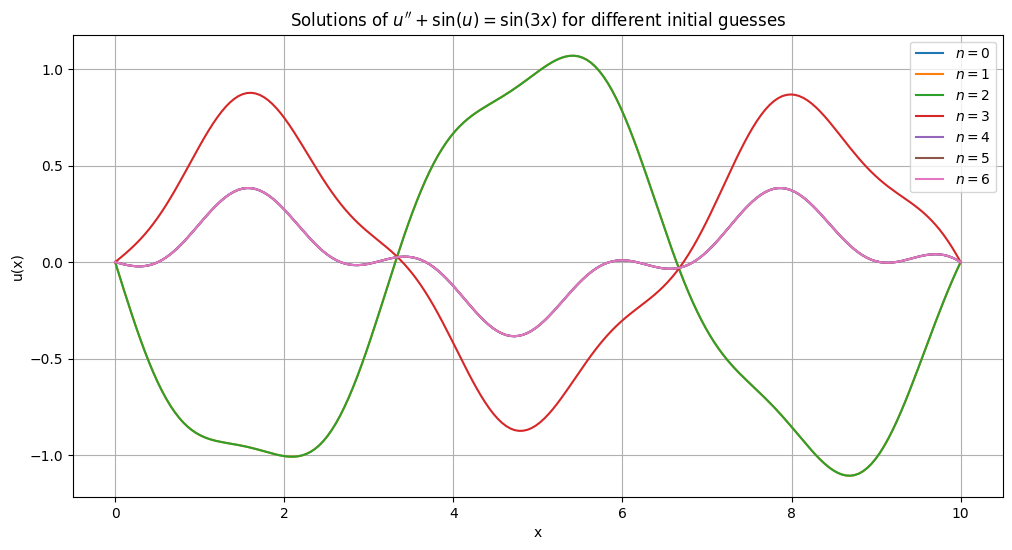

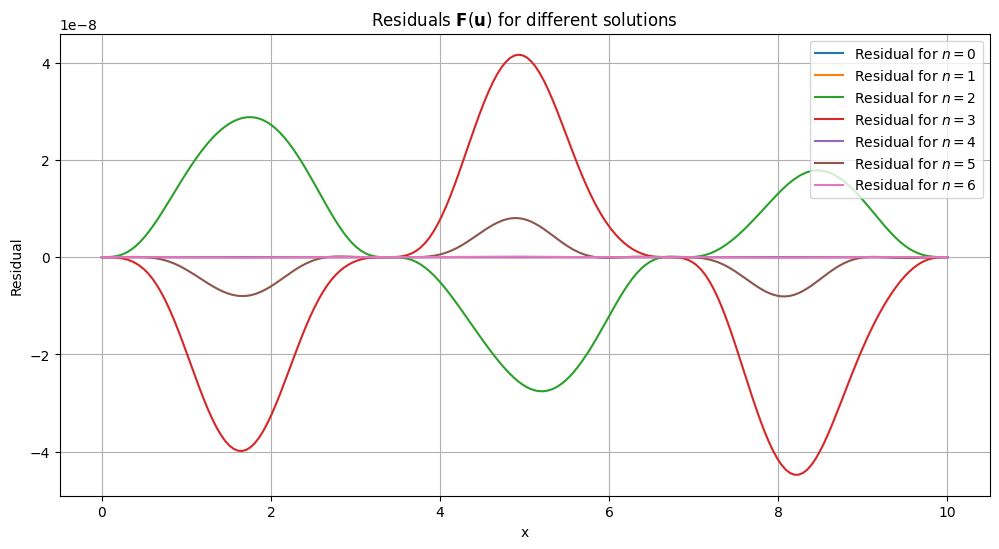

In [64]:
# Initial guesses based on n values
n_values = range(7)  # [0, 1, 2, 3, 4, 5, 6]

# Store solutions and residuals
solutions = []
residuals = []

for n in n_values:
    # Initial condition
    u0 = numpy.sin(n * numpy.pi * x / L)
    u0[0] = 0  # Enforce Dirichlet boundary conditions
    u0[-1] = 0
    
    # Solve the BVP using Newton's method
    try:
        solution, num_iterations= newton(F, J, u0, verbose=False)
        solutions.append(solution)
        residuals.append(F(solution))
    except ValueError as e:
        print(f"Failed to converge for n={n}: {str(e)}")

# Plotting solutions
plt.figure(figsize=(12, 6))
for i, solution in enumerate(solutions):
    plt.plot(x, solution, label=f'$n={n_values[i]}$')
plt.title('Solutions of $u\'\' + \sin(u) = \sin(3x)$ for different initial guesses')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting residuals
plt.figure(figsize=(12, 6))
for i, residual in enumerate(residuals):
    plt.plot(x, residual, label=f'Residual for $n={n_values[i]}$')
plt.title('Residuals $\mathbf{F}(\mathbf{u})$ for different solutions')
plt.xlabel('x')
plt.ylabel('Residual')
plt.legend()
plt.grid(True)
plt.show()

### Extra Fun

Use your shooting routines to systematically search for non-linear solutions to this BVP problem by varying the initial guess for the initial slope $u'(0)$. How many solutions can you find?